In [2]:
import pymongo
import json
import csv

import numpy as np
import pandas as pd

#import seaborn as sns
#print(sns.__version__)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from utils import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
client = pymongo.MongoClient()
col = client['tweets']['december']

In [70]:
col.count()

822618

In [5]:
col.find_one()

{'_id': ObjectId('5a26f3d2b13879ecbb2efc2e'),
 'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Oct 30 11:19:41 +0000 2017',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 924958983005392896,
 'id_str': '924958983005392896',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
  'bounding_box': {'coordinates': [[[-73.972965, 45.410095],
     [-73.972965, 45.705566],
     [-73.473085, 45.705566],
     [-73.473085, 45.410095]]],
   'type': 'Polygon'},
  'country': 'Canada',
  'country_code': 'CA',
  'full_name': 'Montréal, Québec',
  'id': '36775d842cbec509',
  'name': 'Montréal',
  'place_type': 'city',
  'url': 'https://api.twitter.com/1.1/geo/id/36775d842cbec509.json'},
 

In [35]:
%%time

tweets_df = [{"created_at": item["created_at"],
              "text": item["text"].encode('unicode_escape'),
              "hashtags": ','.join([i['text'] for i in item['entities']['hashtags']]),
              "user": "@%s" % item["user"]["screen_name"],
              "placename": item['place']['full_name'],
              "province": item['place']['full_name'].split(', ')[-1],
              "city": item['place']['name'],
              "country": item['place']['country'],
              "source": item["source"] if item["source"] else '',
              "lang": item['lang'],              
              "latitude": item['geo']['coordinates'][0] if item['geo'] else np.nan,
              "longitude": item['geo']['coordinates'][1] if item['geo'] else np.nan
              
            } for item in col.find({"place.country_code": "CA"})]
tweets_df = pd.DataFrame(tweets_df)
tweets_df.head()

CPU times: user 2min 28s, sys: 3.37 s, total: 2min 32s
Wall time: 2min 34s


## Tweet language

In [19]:
tweets_df = pd.read_csv('./data/tweets_december.csv')
tweets_df.head()

,city,country,created_at,hashtags,lang,latitude,longitude,placename,province,source,text,user
0,Montréal,Canada,Mon Oct 30 11:19:41 +0000 2017,NaN,en,NaN,NaN,"Montréal, Québec",Québec,"<a href=""http://twitter.com/download/iphone"" r...",b'Fed up with people volontarily wasting their...,@amanniste
1,Saint John,Canada,Mon Oct 30 11:19:43 +0000 2017,NaN,en,NaN,NaN,"Saint John, New Brunswick",New Brunswick,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","b'@imjmichaels I love your performance, your ...",@Joshstylegaming
2,Laval,Canada,Mon Oct 30 11:19:40 +0000 2017,"DodgersVsAstros,ExtraInnings,MLBWorldSeries",en,NaN,NaN,"Laval, Québec",Québec,"<a href=""http://twitter.com/download/iphone"" r...",b'What a game #DodgersVsAstros #ExtraInnings !...,@Pizma
3,Vancouver,Canada,Mon Oct 30 11:19:52 +0000 2017,nowplaying,en,49.271643,-123.069455,"Vancouver, British Columbia",British Columbia,"<a href=""http://www.vjukebox.com"" rel=""nofollo...","b""The Whole World by OutKast is #nowplaying in...",@StartleMusic
4,Canada,Canada,Mon Oct 30 11:19:58 +0000 2017,NaN,en,NaN,NaN,Canada,Canada,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","b'""EL DIA PERDIDO EN LA HISTORIA ""\\nPastor Do...",@zingholdings


In [20]:
print("Total # tweets:", len(tweets_df))
print("English tweets:", len(tweets_df.loc[tweets_df.lang == 'en']))
print("French tweets:", len(tweets_df.loc[tweets_df.lang == 'fr']))
print("Other language:", len(tweets_df.loc[(tweets_df.lang != 'en') & (tweets_df.lang != 'fr')]))

Total # tweets: 708586
English tweets: 677514
French tweets: 31072
Other language: 0


In [37]:
tweets_df = tweets_df.drop(tweets_df.loc[(tweets_df.lang != 'en') & (tweets_df.lang != 'fr')].index).reset_index(drop=True)

In [50]:
tweets_df.to_csv('./data/tweets_december.csv', index=False)

## Source client used by the user

Trendinalia Canada       3870
Foursquare               3969
CUBE Live Feed App       7707
Tweetbot for iΟS         8153
Twitter for iPad        13035
TweetMyJOBS             21923
Instagram               66595
Twitter Web Client      90988
Twitter for Android    155771
Twitter for iPhone     305682
Name: source, dtype: int64

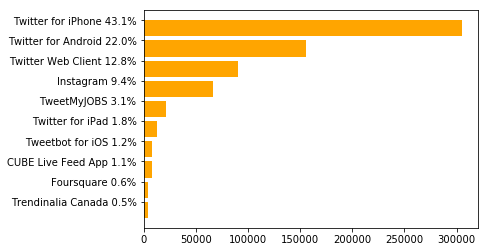

In [21]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""

tweets_df.source_name = tweets_df.source.apply(get_source_name)

source_counts = tweets_df.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="orange", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(tweets_df)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
source_counts

## Tweets by region

In [67]:
tweets_df['text'] = tweets_df['text'].astype(str)
tweets_df['hashtags'] = tweets_df['hashtags'].astype(str)
regions_df = tweets_df.groupby(['placename']).apply(filter_tweets)
regions_df = regions_df.sort_values('num_tweets', ascending=False)
regions_df.head()

/home/vmadmin/hdbc/utils.py:158: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  sedentary_behavior = count_topic(x, sedentary_pattern),
/home/vmadmin/hdbc/utils.py:159: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  sleeping = count_topic(x, sleeping_pattern),


,latitude,longitude,num_tweets,physical_activity,sedentary_behavior,sleeping
placename,,,,,,
"Toronto, Ontario",43.684190,-79.384684,141155.0,16433.0,13391.0,6408.0
"Ottawa, Ontario",45.389153,-75.702170,38949.0,5046.0,4301.0,1989.0
"Montréal, Québec",45.508894,-73.585537,35156.0,3274.0,3146.0,1096.0
"Calgary, Alberta",51.040558,-114.071119,33440.0,4204.0,4746.0,3100.0
"Vancouver, British Columbia",49.266033,-123.103556,32934.0,3720.0,3241.0,1541.0


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


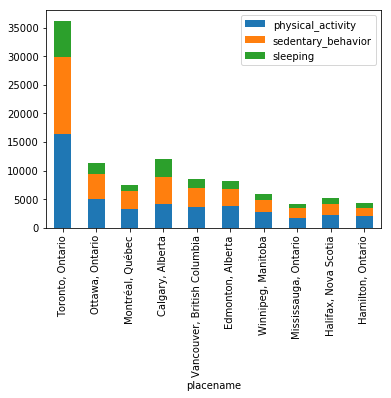

In [68]:
regions_df.ix[:10, ['physical_activity', 'sedentary_behavior', 'sleeping']].plot(kind='bar', stacked=True)

num_tweets            708586.0
physical_activity      85708.0
sedentary_behavior     73762.0
sleeping               38518.0
dtype: float64


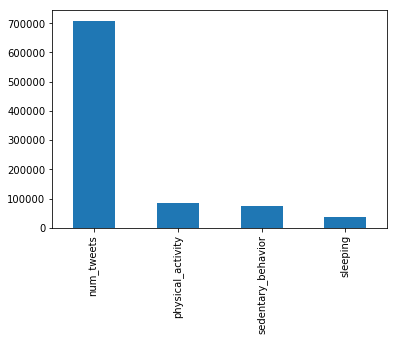

In [69]:
print(regions_df.loc[:, 'num_tweets':].sum())
regions_df.loc[:, 'num_tweets':].sum().plot(kind='bar')

## Checking the highest used words

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(tweets_df.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]